### Libraries

In [30]:
import os
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import copy
from skimage import io

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
import numpy as np

from src.data import ImageSegmentationDataset
from src.models import CNN, UNet, UNetPlusPlus, ViTConvSegmenter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


### Global Variables

In [31]:
TRAIN_IMAGE_FOLDER = '.data/flair_1_toy_aerial_train'
TEST_IMAGE_FOLDER = '.data/flair_1_toy_aerial_test'
INPUT_CHANNELS = 5
OUTPUT_CHANNELS = 13
IMAGE_SIZE = 240

BATCH_SIZE = 8
EPOCHS = 10


flair_data = {
    1   : ['building','#db0e9a'] ,
    2   : ['pervious surface','#938e7b'],
    3   : ['impervious surface','#f80c00'],
    4   : ['bare soil','#a97101'],
    5   : ['water','#1553ae'],
    6   : ['coniferous','#194a26'],
    7   : ['deciduous','#46e483'],
    8   : ['brushwood','#f3a60d'],
    9   : ['vineyard','#660082'],
    10  : ['herbaceous vegetation','#55ff00'],
    11  : ['agricultural land','#fff30d'],
    12  : ['plowed land','#e4df7c'],
    13  : ['swimming_pool','#3de6eb'],
    14  : ['snow','#ffffff'],
    15  : ['clear cut','#8ab3a0'],
    16  : ['mixed','#6b714f'],
    17  : ['ligneous','#c5dc42'],
    18  : ['greenhouse','#9999ff'],
    19  : ['other','#000000'],
}

labels = [flair_data[x][0] for x in flair_data]
colormap =  [flair_data[x][1] for x in flair_data]

### How files and masks looks like

In [32]:
def show_images(images):
  fig, axis = plt.subplots(1, len(images), figsize=(len(images) * 4, len(images) * 5))

  for idx, image in enumerate(images):
    image = image.type(torch.uint8)
    if len(image.shape) == 2:
      image = image.unsqueeze(dim=0)
      
    image = axis[idx].imshow(image.permute(1, 2, 0))

  plt.show()

In [33]:
def mask_image(mask, colormap, n_colors=13):

    mask = mask.type(torch.uint8)
    if len(mask.shape) == 2:
      mask = mask.unsqueeze(dim=0)


    # Define the colors (13 distinct colors)
    cmap = mcolors.ListedColormap(colormap)

    # Normalize the colormap
    bounds = np.arange(0.5, n_colors+1, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    return mask, cmap, norm

In [34]:
def show_mask(mask, colormap, labels, n_colors=13):

    mask, cmap, norm = mask_image(mask, colormap, n_colors)

    # Create the plot
    fig, ax = plt.subplots()
    mask = ax.imshow(mask.permute(1, 2, 0), cmap=cmap, norm=norm)

    # Optional: Add color bar with appropriate ticks
    cbar = fig.colorbar(mask, ticks=np.arange(1, n_colors+1))
    cbar.ax.set_yticklabels(labels)

    # Show the plot
    plt.show()


In [35]:
def show_images_and_masks(images, masks, n_colors=13):
  im_len = len(images) + len(masks)
  fig, axis = plt.subplots(1, im_len, figsize=(im_len * 4, im_len * 5))

  for idx, image in enumerate(images):
    image = image.type(torch.uint8)
    if len(image.shape) == 2:
      image = image.unsqueeze(dim=0)
      
    image = axis[idx].imshow(image.permute(1, 2, 0))

  for idx, mask in enumerate(masks):
    mask = mask.type(torch.uint8)
    if len(mask.shape) == 2:
      mask = mask.unsqueeze(dim=0)
      
    mask, cmap, norm = mask_image(mask, colormap, n_colors)

    mask = axis[idx + len(images)].imshow(mask.permute(1, 2, 0), cmap=cmap, norm=norm)

  plt.show()

In [36]:
mask = io.imread('.data/flair_1_toy_labels_train/D035_2020/Z3_UA/msk/MSK_026246.tif')
mask = torch.as_tensor(mask)

image = io.imread('.data/flair_1_toy_aerial_train/D035_2020/Z3_UA/img/IMG_026246.tif')
image_rgb = torch.as_tensor(image[:, : , :3]).permute(2, 0, 1)  
image_nir = torch.as_tensor(image[:, : , 3])
image_el = torch.as_tensor(image[:, : , 4])

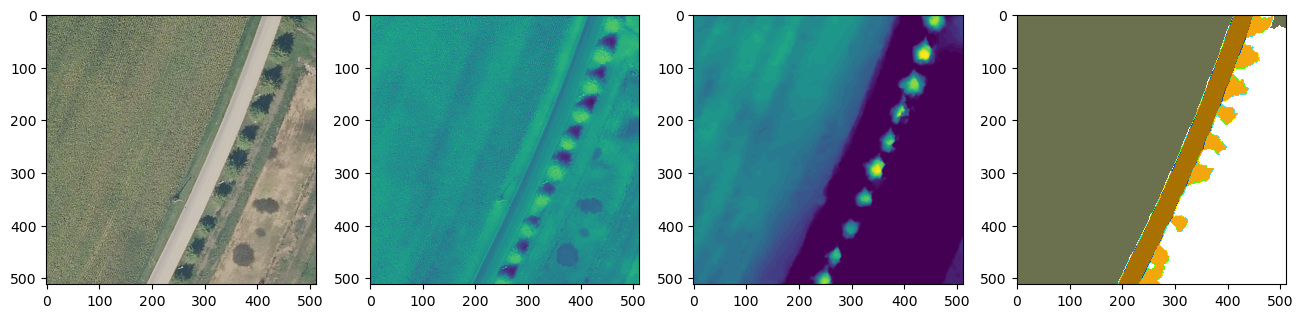

In [37]:
show_images_and_masks([image_rgb, image_nir, image_el], [mask])

In [38]:
image_nir.shape

torch.Size([512, 512])

In [39]:
image_nir.shape

torch.Size([512, 512])

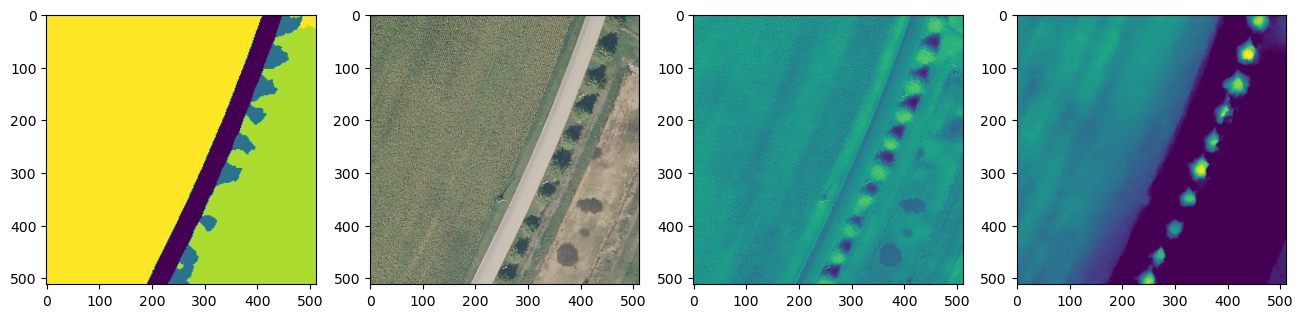

In [40]:
show_images([mask, image_rgb, image_nir, image_el])

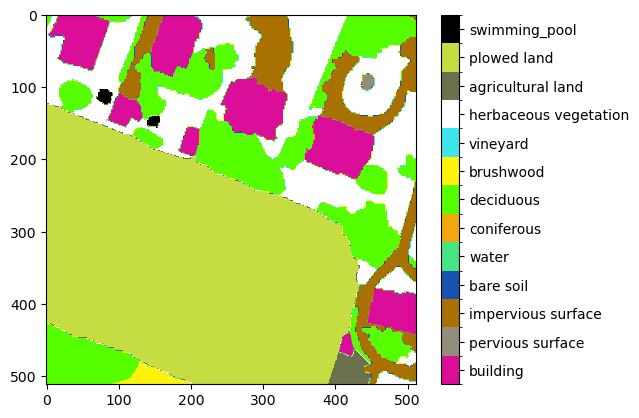

In [41]:
#This needs some changes, to have better colors. But it works, and will show value for each of 

mask = io.imread('.data/flair_1_toy_labels_train/D032_2019/Z1_AA/msk/MSK_021680.tif')
mask = torch.as_tensor(mask)
show_mask(mask, colormap, labels[:13], OUTPUT_CHANNELS)

In [42]:
def list_all_files(dir: str, ext: str='.tif') -> list: 
    files_list = []

    for root, _, files in os.walk(dir):
        for file in files:
            file_name = os.path.join(root, file)
            
            if file_name[-4:] == ext:
                files_list.append(file_name)

    return files_list

### Image and Mask file mapping

Due to how dataset is created, I used walker/crawler to get all image files in TRAIN_IMAGE_FOLDER. Then, to get data for mask with the same order I could one more time use crawler/walker and sort outputs. But to make it simpler I replaced certain string parts to get the same mask file.

In [43]:
X_train = list_all_files(TRAIN_IMAGE_FOLDER)
y_train = [x.replace('aerial_train', 'labels_train').replace('img', 'msk').replace('IMG', 'MSK') for x in X_train]

X_test = list_all_files(TEST_IMAGE_FOLDER)
y_test = [x.replace('aerial_test', 'labels_test').replace('img', 'msk').replace('IMG', 'MSK') for x in X_test]

In [44]:
# We could either use this or save it and use it as CSV

train_df = pd.DataFrame({'IMG': X_train, 'MSK': y_train})
test_df = pd.DataFrame({'IMG': X_test, 'MSK': y_test})

train_df.to_csv('csv/flair_train.csv', index=False)
test_df.to_csv('csv/flair_test.csv', index=False)

In [45]:
transform = transforms.Compose([
    transforms.Resize([IMAGE_SIZE, IMAGE_SIZE])
])

# transform = None

In [46]:
train_dataset = ImageSegmentationDataset(
    dir_file='csv/flair_train.csv',
    n_channels = INPUT_CHANNELS,
    n_classes = OUTPUT_CHANNELS,
    transform = transform, # add more transform functions
)

test_dataset = ImageSegmentationDataset(
    dir_file='csv/flair_test.csv',
    n_channels = INPUT_CHANNELS,
    n_classes = OUTPUT_CHANNELS,
    transform = transform, # add more transform functions
)

In [47]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader= DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [48]:
def one_hot_decoding(one_hot_matrix: torch.Tensor) -> torch.Tensor:
    return torch.argmax(one_hot_matrix, dim=0)

eg_image = test_dataset[0]
mask_decoded = one_hot_decoding(eg_image[1])
image_rgb = eg_image[0][:3, :, :]
image_nir = eg_image[0][3, :, :]
image_el = eg_image[0][4, :, :]

print(torch.max(image_el))

tensor(91.6501)


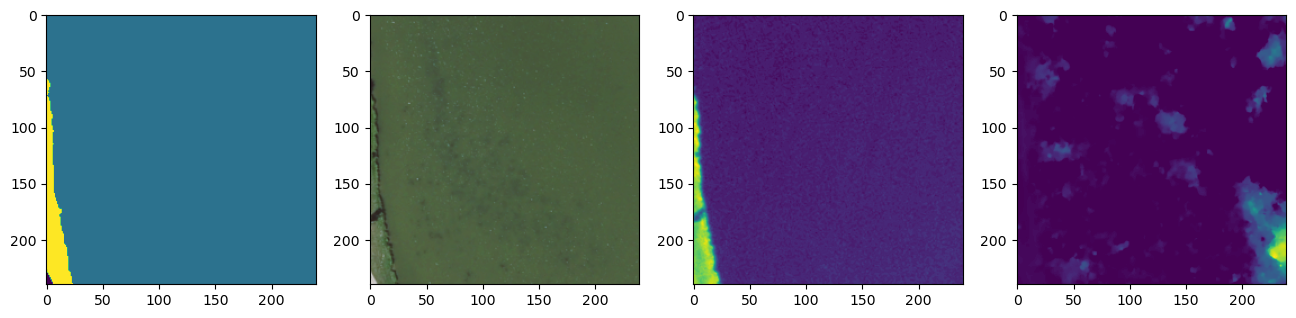

In [49]:
show_images([mask_decoded, image_rgb, image_nir, image_el])
# show_images([mask_decoded, image_rgb])

In [50]:
def evaluate_model(model, data_loader, device):
    """
    Evaluates a trained model on a given dataset.

    Args:
        model: Model architecture to evaluate.
        data_loader: The data loader of the dataset to evaluate on.
        device: Device to use for training.
    Returns:
        accuracy: The accuracy on the dataset.

    """
    model.to(device)
    # Set model to evaluation mode (Remember to set it back to training mode in the training loop)
    model.eval()
    # Loop over the dataset and compute the accuracy. Return the accuracy
    # Remember to use torch.no_grad().
    batch_sizes, accs = [], []
    # calculate the metrics for each batch
    with torch.no_grad():
        for X_test, y_test in data_loader:
            X_test = X_test.to(device)
            y_test = one_hot_decoding(y_test.to(device).squeeze())
            preds = one_hot_decoding(model(X_test).squeeze())
            batch_sizes.append(X_test.shape[0])

            correct = (preds == y_test).sum()
            total = preds.numel()
            acc = correct / total
            accs.append(acc.item())
    # calculate the average accuracy for the whole dataset, weighted by batch size
    accuracy = np.average(accs, weights=batch_sizes)

    return accuracy

In [51]:
def predict(tensor, model):
    model.eval()
    model.to('cpu')
    tensor = tensor.type(torch.FloatTensor)
    predict = model(tensor.unsqueeze(0))
    predict = predict.clone().detach()
    return predict

In [52]:
# model = UNet(INPUT_CHANNELS, OUTPUT_CHANNELS)
# model.__dict__

Epoch 1/10
Train acc: 29.49% | Training loss: 2.1575


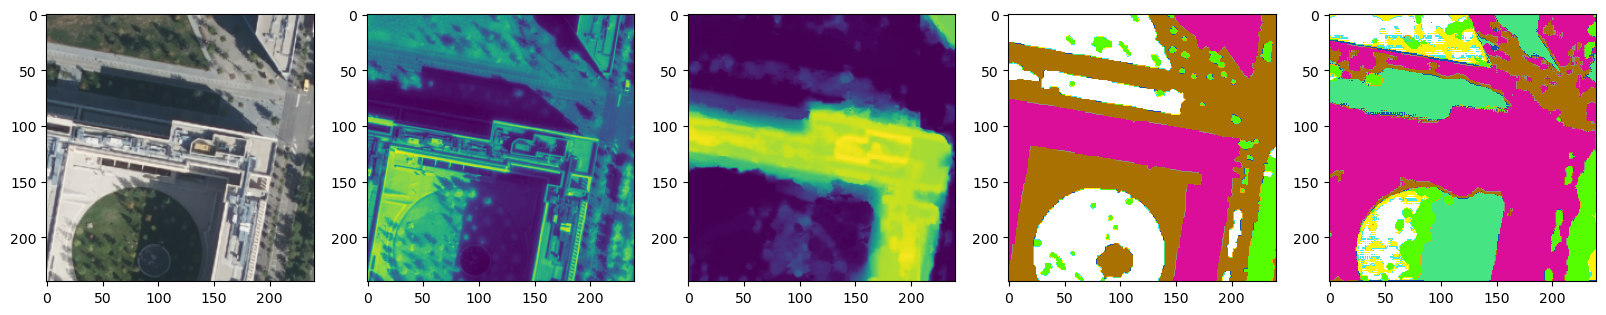

Epoch 2/10
Train acc: 33.24% | Training loss: 2.0131


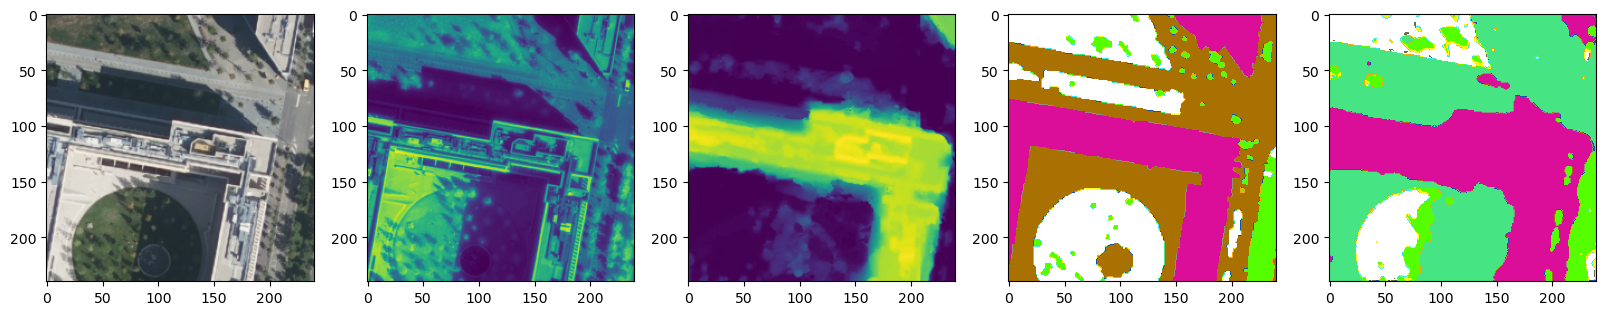

Epoch 3/10
Train acc: 30.13% | Training loss: 1.9392


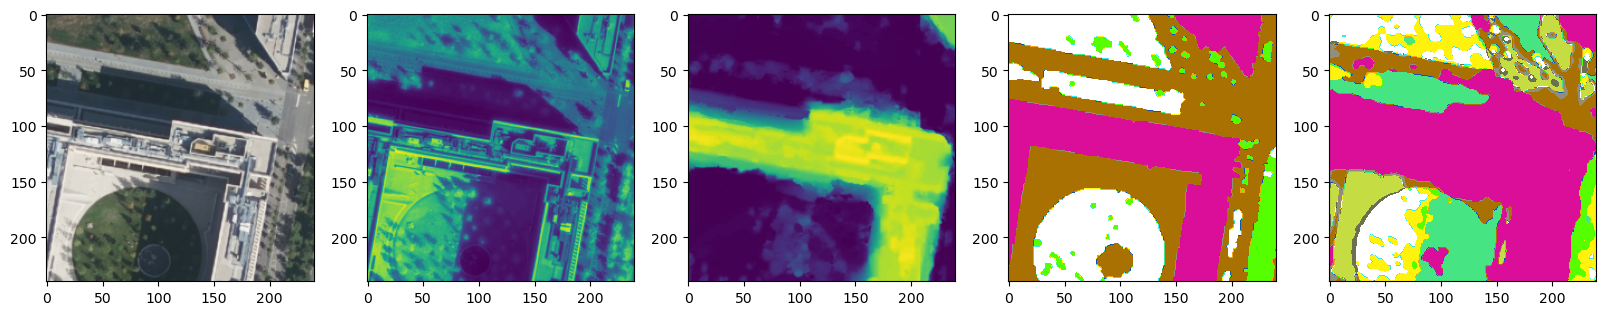

Epoch 4/10
Train acc: 30.33% | Training loss: 1.9619


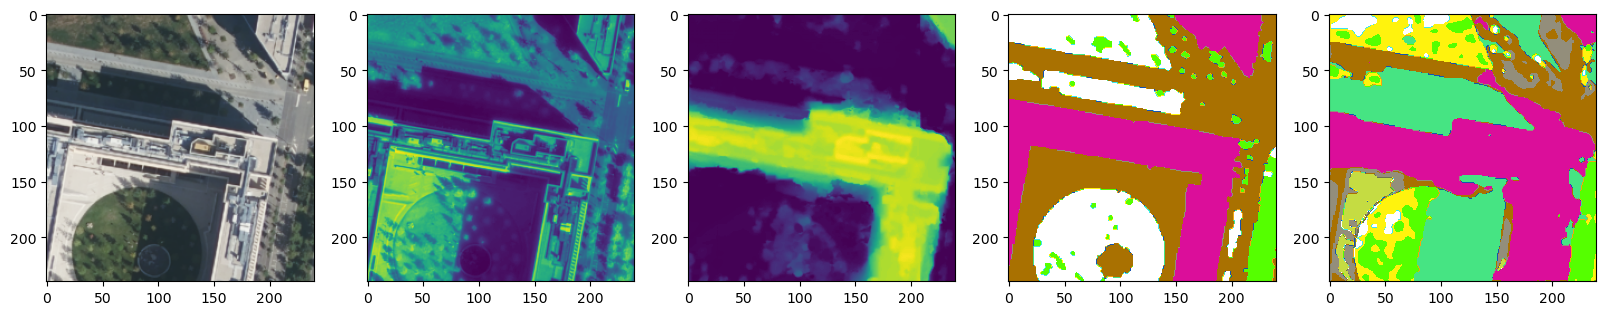

Epoch 5/10
Train acc: 31.77% | Training loss: 1.8883


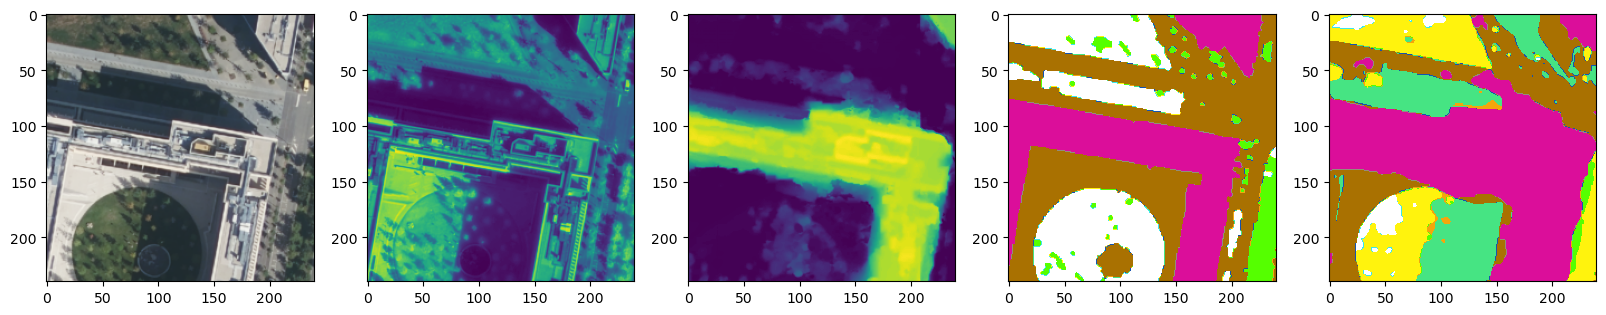

Epoch 6/10
Train acc: 32.29% | Training loss: 1.8045


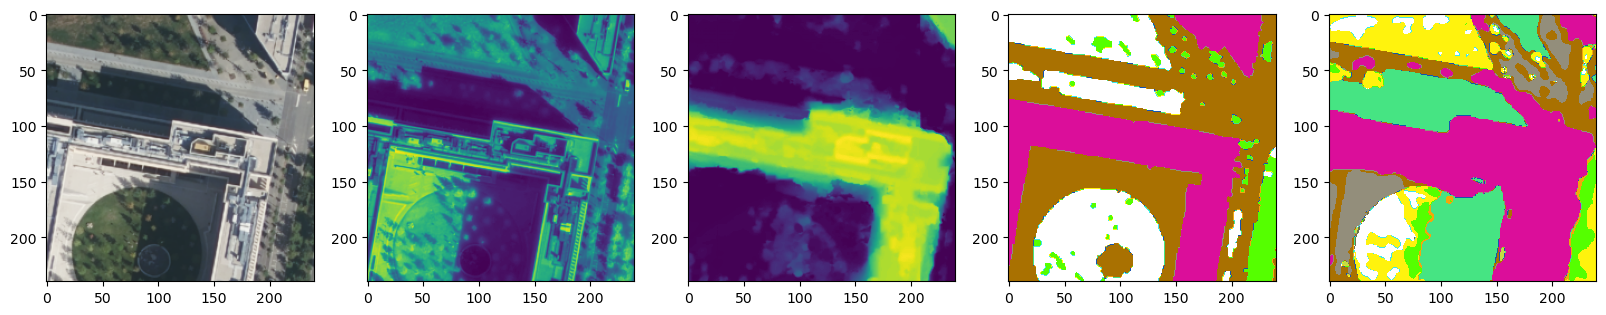

Epoch 7/10
Train acc: 30.93% | Training loss: 1.8564


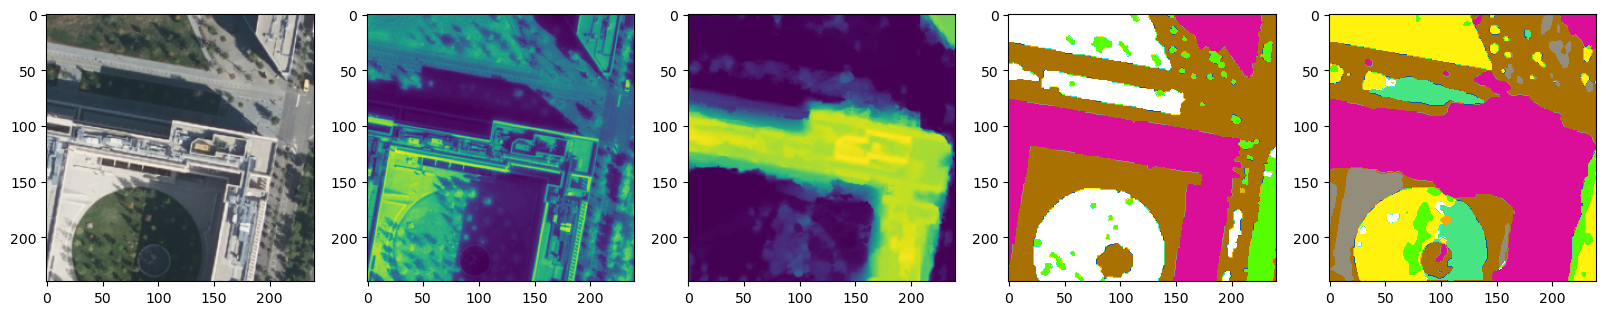

Epoch 8/10
Train acc: 30.38% | Training loss: 1.8086


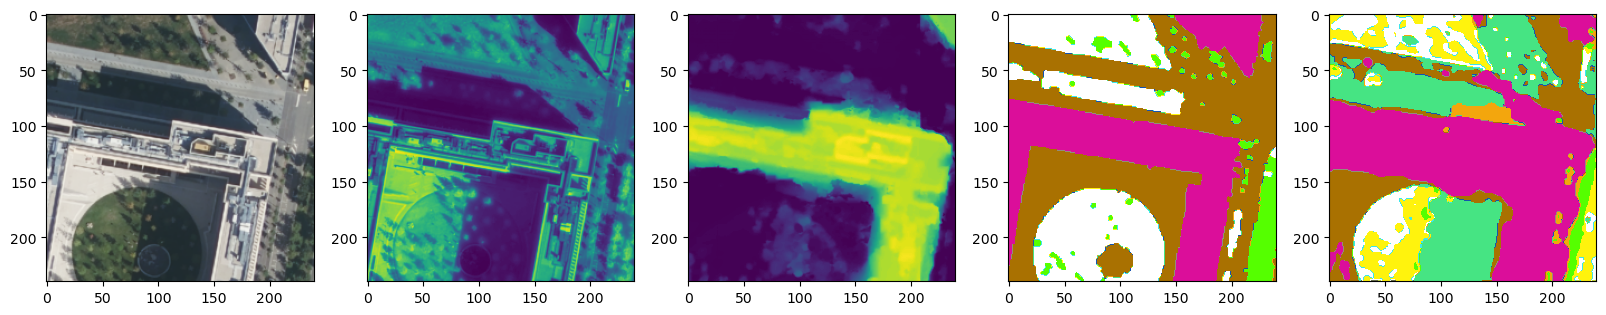

Epoch 9/10
Train acc: 30.54% | Training loss: 1.7799


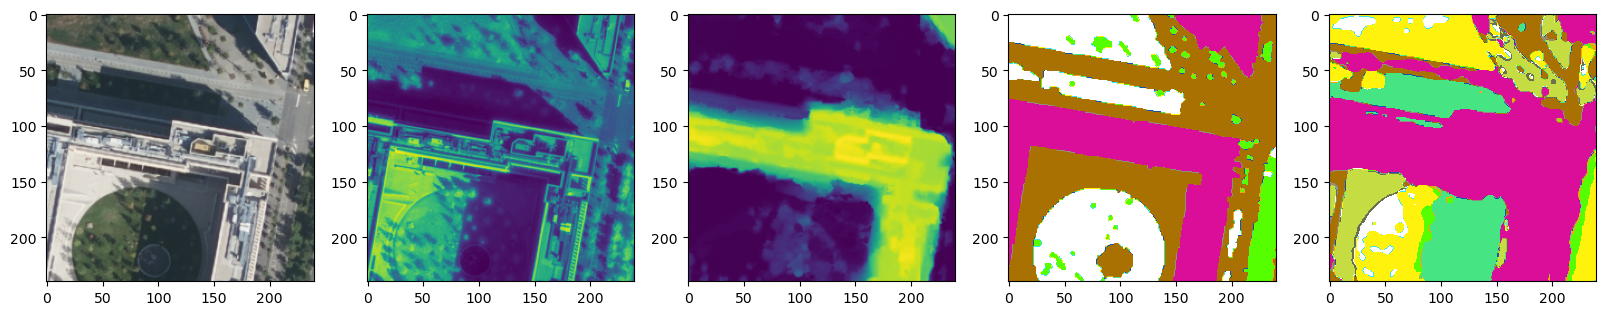

Epoch 10/10
Train acc: 32.19% | Training loss: 1.7485


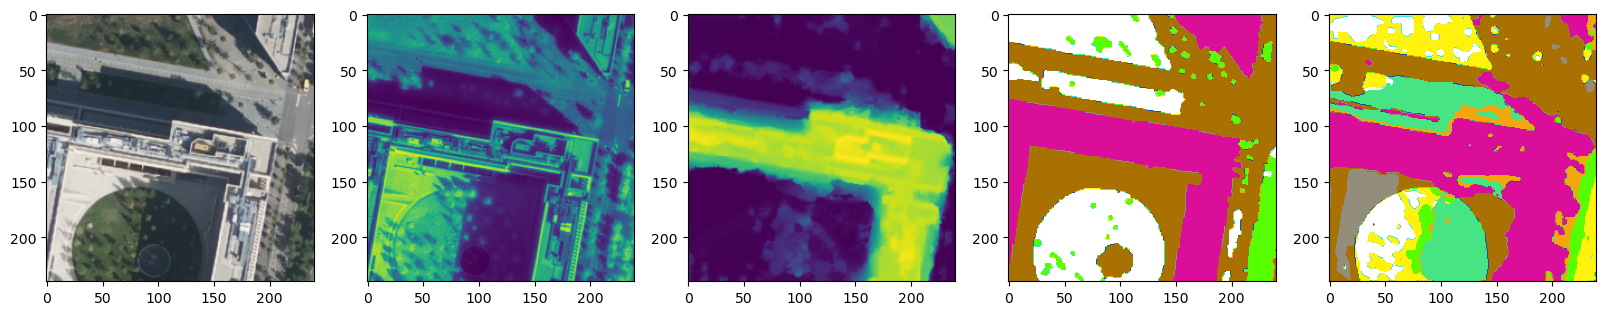

In [53]:
# model = CNN()
# model = UNet(INPUT_CHANNELS, OUTPUT_CHANNELS)
model = UNetPlusPlus(INPUT_CHANNELS, OUTPUT_CHANNELS)
# model = ViTConvSegmenter(
#             image_size=IMAGE_SIZE,
#             patch_size= 16, 
#             in_channels = INPUT_CHANNELS, 
#             num_classes = OUTPUT_CHANNELS, 
#             embedding_dim = 768, 
#             num_layers = 12, 
#             num_heads = 12, 
#             hidden_dim = 3072, 
#             attention_dropout = 0.1,
#             fc_out_dropout = 0.1,
#             mlp_dropout = 0.1)

model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(
#     model.parameters(),
#     lr=0.1,
#     alpha=0.9,
#     eps=1e-7,
#     weight_decay=0
# )

best_acc = -1

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    train_losses_epoch, val_losses_epoch = [], []
    # train
    model.train()
    for (X_train, y_train) in train_dataloader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        pred_mask = model(X_train)

        loss = criterion(pred_mask, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses_epoch.append(loss.item())

    train_iou = evaluate_model(model, test_dataloader, device)
    # train_accs.append(train_acc)
    train_loss = np.mean(train_losses_epoch)
    # train_losses.append(train_loss)
    print(f'Train acc: {train_iou*100:.2f}% | Training loss: {train_loss:.4f}')

    if epoch == 1 or epoch % 1 == 0:
        eg_image = train_dataset[0]

        output = predict(eg_image[0], model=copy.deepcopy(model))
        mask_decoded = one_hot_decoding(eg_image[1])
        image_rgb = eg_image[0][:3, :, :]
        image_nir = eg_image[0][3, :, :]
        image_el = eg_image[0][4, :, :]

        show_images_and_masks([image_rgb, image_nir, image_el], [mask_decoded, one_hot_decoding(output.squeeze())], n_colors=OUTPUT_CHANNELS)
        # show_images([image_rgb, mask_decoded, one_hot_decoding(output.squeeze())])
        plt.show()


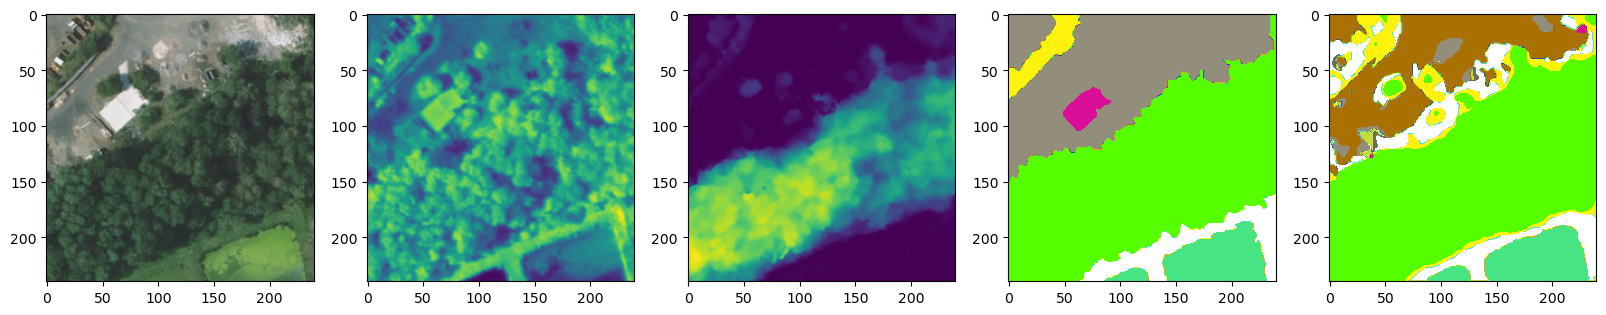

In [59]:
eg_image = test_dataset[1]

output = predict(eg_image[0], model=copy.deepcopy(model))
mask_decoded = one_hot_decoding(eg_image[1])
image_rgb = eg_image[0][:3, :, :]
image_nir = eg_image[0][3, :, :]
image_el = eg_image[0][4, :, :]

show_images_and_masks([image_rgb, image_nir, image_el], [mask_decoded, one_hot_decoding(output.squeeze())], n_colors=OUTPUT_CHANNELS)
# show_images([image_rgb, mask_decoded, one_hot_decoding(output.squeeze())])
plt.show()

In [60]:
dic = {}
for row in mask_decoded:
    for cell in row:
        cell =  cell.item()
        if cell in dic:
            dic[cell] += 1
        else:
            dic[cell] = 1

print(dic)


dic = {}
for row in one_hot_decoding(output.squeeze()):
    for cell in row:
        cell =  cell.item()
        if cell in dic:
            dic[cell] += 1
        else:
            dic[cell] = 1

print(dic)

{2: 18558, 8: 1612, 7: 29202, 1: 887, 10: 3536, 5: 3805}
{3: 11209, 8: 4413, 7: 29868, 2: 1297, 10: 6325, 6: 5, 1: 70, 12: 301, 4: 3, 11: 204, 5: 3905}


In [61]:
output.shape

torch.Size([1, 13, 240, 240])

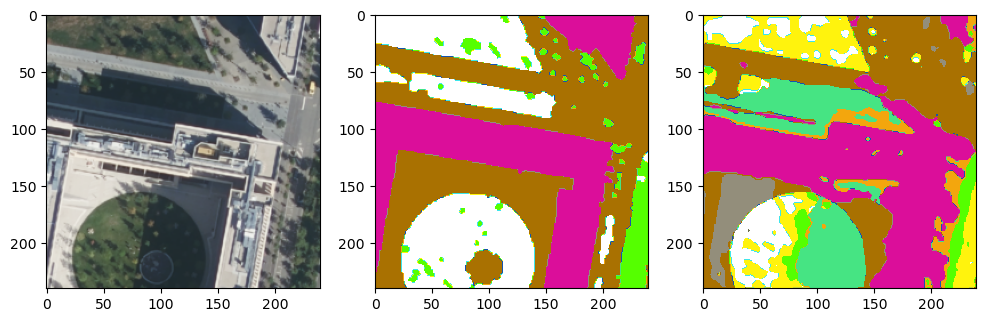

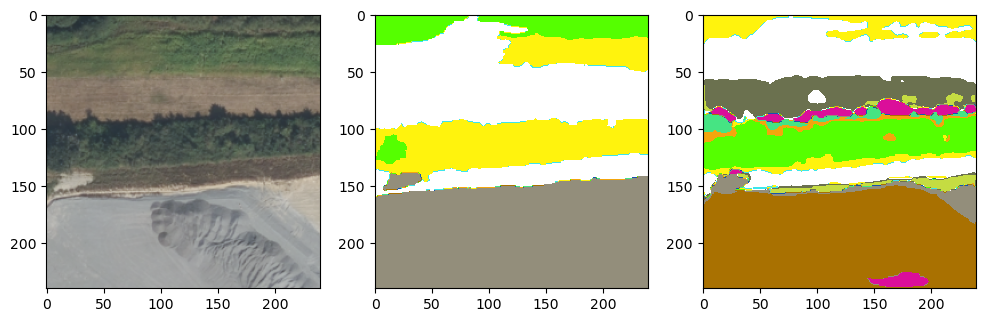

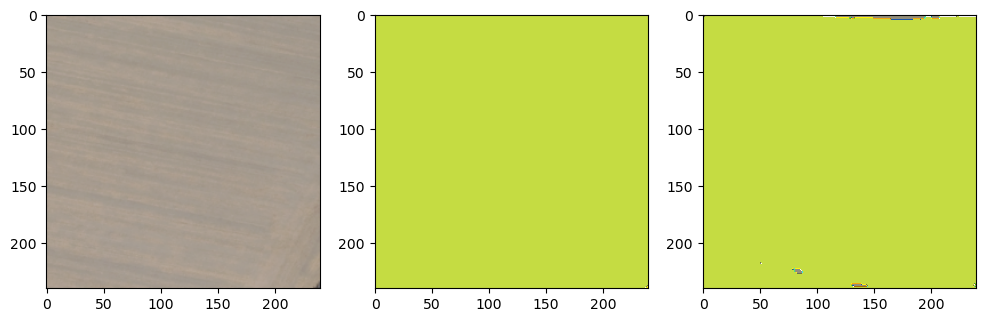

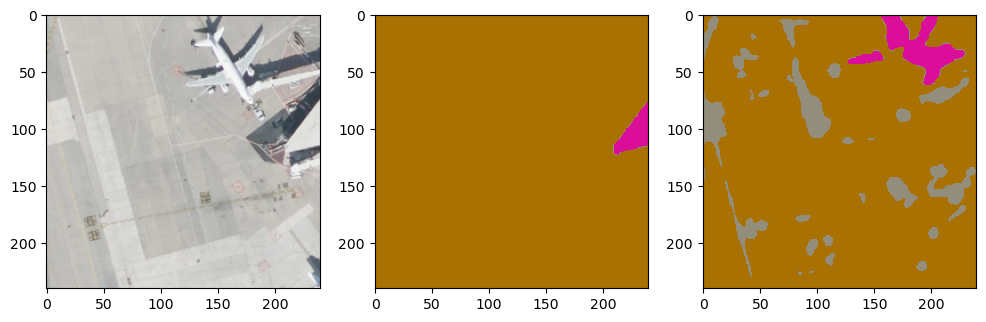

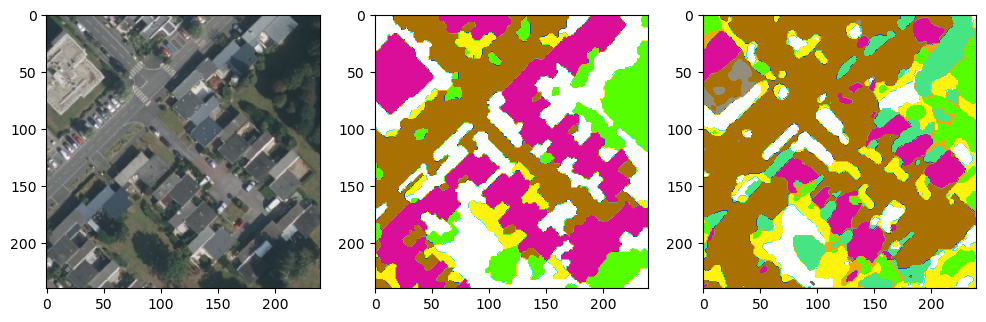

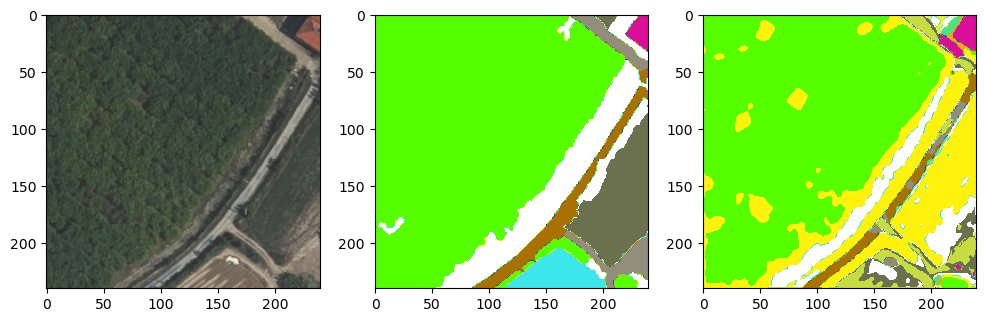

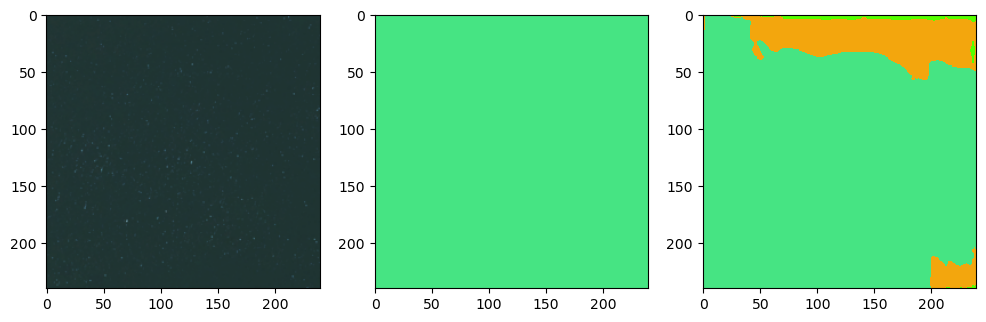

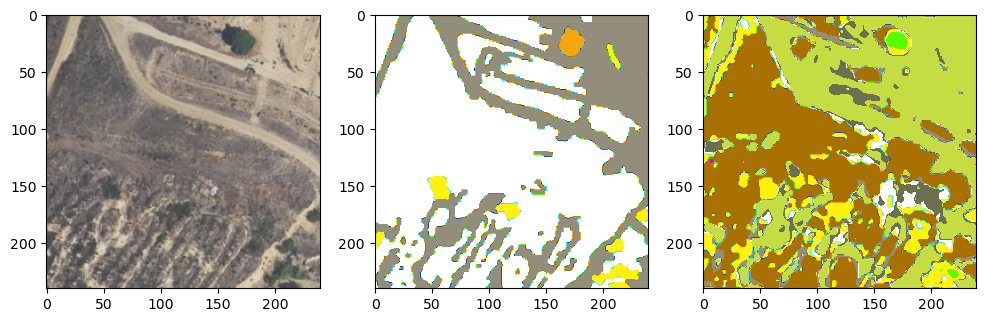

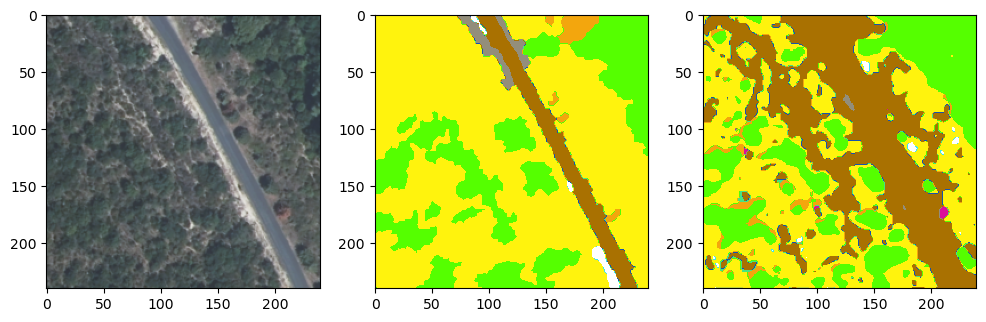

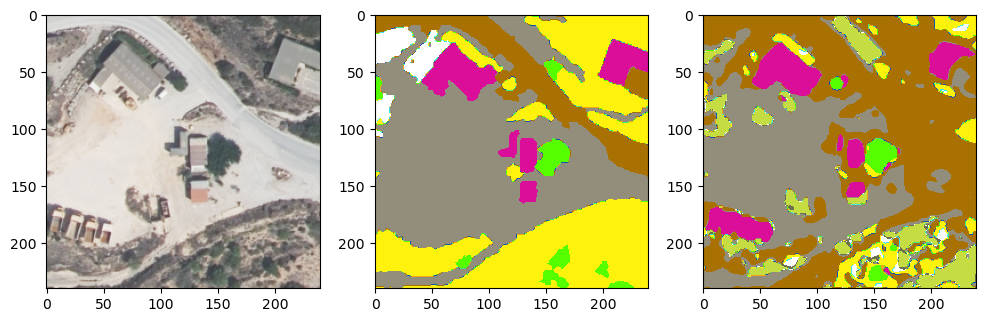

In [65]:
for i in range(10):
  pred_image = train_dataset[i]
  output = predict(pred_image[0], model)
  show_images_and_masks([pred_image[0][:3, :, :]], [ one_hot_decoding(pred_image[1]), one_hot_decoding(output.squeeze())], n_colors=OUTPUT_CHANNELS)

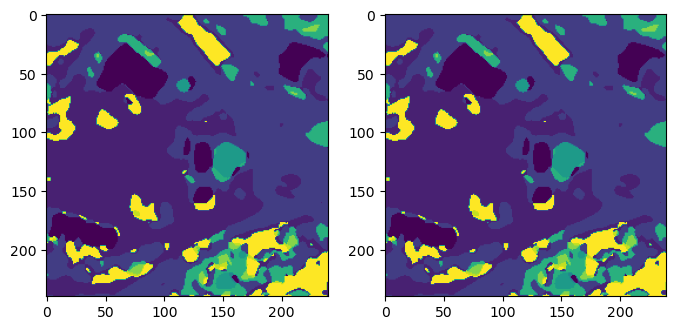

In [58]:
show_images([one_hot_decoding(output.squeeze()), one_hot_decoding(output.squeeze())])